# Machine Learning in Finance (Seminar) - Group 1

## 1 Imports

### 1.1 Python imports

In [1]:
import sys
!{sys.executable} -m pip install nbimporter
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install keras
!{sys.executable} -m pip install tensorflow
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import nbimporter
from collections import Counter
from Helpers import helper_functions
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, cross_val_score, StratifiedKFold, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

### 1.2 Data imports

Reading the five datasets from the Data folder (The files were downloaded from Kaggle and uploaded to the repository manually). We than add the additional column 'SP500' to every dataframe including the annual performance of the SP500 according to this source: https://www.macrotrends.net/2526/sp-500-historical-annual-returns. We there downloaded the historical data on Thursday, 04.03.2021. The corresponding file 'sp-500-historical-annual-returns.csv' can be found in our folder 'Data'.

In [2]:
#load data sets
df_2014 = pd.read_csv('Data/2014_Financial_Data.csv')
df_2015 = pd.read_csv('Data/2015_Financial_Data.csv')
df_2016 = pd.read_csv('Data/2016_Financial_Data.csv')
df_2017 = pd.read_csv('Data/2017_Financial_Data.csv')
df_2018 = pd.read_csv('Data/2018_Financial_Data.csv')

#load S&P-500 data set
df_SP500 = pd.read_csv('Data/sp-500-historical-annual-returns.csv')

## 2 Dataset Preparation

### 2.1 Organising Data Frames

In [3]:
#rename price variation columns for later concatenation of the different data frames
df_2014 = df_2014.rename(columns={"2015 PRICE VAR [%]": "PRICE VAR [%]"})
df_2015 = df_2015.rename(columns={"2016 PRICE VAR [%]": "PRICE VAR [%]"})
df_2016 = df_2016.rename(columns={"2017 PRICE VAR [%]": "PRICE VAR [%]"})
df_2017 = df_2017.rename(columns={"2018 PRICE VAR [%]": "PRICE VAR [%]"})
df_2018 = df_2018.rename(columns={"2019 PRICE VAR [%]": "PRICE VAR [%]"})

    
all_dfs = [df_2014, df_2015, df_2016, df_2017, df_2018]
for i in range(len(all_dfs)):
    current_df = all_dfs[i]
  
    #drop row entries consisting of only nan values
    current_df.dropna(how = 'all', inplace = True)
    
    #drop class column and name of share column
    current_df = current_df.drop(columns = ['Class', 'Unnamed: 0'], inplace=True)

Firstly, we want to get an overview of the data which we deal with. One important property is the Sector and their distribution.

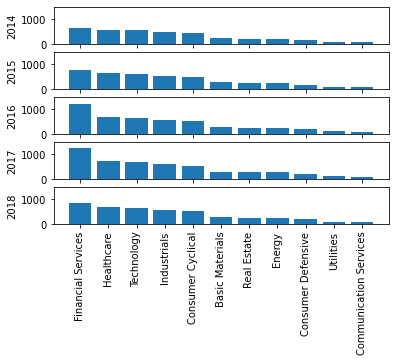

In [4]:
#Plotting the sector distributions
df_2014_sector = df_2014['Sector'].value_counts()
df_2015_sector = df_2015['Sector'].value_counts()
df_2016_sector = df_2016['Sector'].value_counts()
df_2017_sector = df_2017['Sector'].value_counts()
df_2018_sector = df_2018['Sector'].value_counts()
       
plt.title('Observations Sector Distribution', fontsize=20)
plt.subplot(5, 1, 1)
year_2014 = plt.bar(np.arange(len(df_2014_sector)), df_2014_sector)
plt.ylabel('2014')
plt.ylim([0, 1500])

plt.subplot(5, 1, 2)
year_2015 = plt.bar(np.arange(len(df_2015_sector)), df_2015_sector)
plt.ylabel('2015')
plt.ylim([0, 1500])

plt.subplot(5, 1, 3)
year_2016 = plt.bar(np.arange(len(df_2016_sector)), df_2016_sector)
plt.ylabel('2016')
plt.ylim([0, 1500])

plt.subplot(5, 1, 4)
year_2017 = plt.bar(np.arange(len(df_2017_sector)), df_2017_sector)
plt.ylabel('2017')
plt.ylim([0, 1500])

plt.subplot(5,1,5)
year_2018 = plt.bar(np.arange(len(df_2018_sector)), df_2018_sector)
plt.ylabel('2018')
plt.ylim([0, 1500])
plt.xticks(np.arange(len(df_2018_sector)), df_2018_sector.index.values.tolist(), rotation = 90)

plt.show()

We clearly see that some Sectors appear more often than others. And we also see that the dataframes don't have the same size. We decide to add boolean columns for all years. These year columns and the Sector will be part of our most important features.

In [5]:
#add year columns as booleans
df_2014['year_2014'] = 1
df_2014['year_2015'] = 0
df_2014['year_2016'] = 0
df_2014['year_2017'] = 0
df_2014['year_2018'] = 0

df_2015['year_2014'] = 0
df_2015['year_2015'] = 1
df_2015['year_2016'] = 0
df_2015['year_2017'] = 0
df_2015['year_2018'] = 0

df_2016['year_2014'] = 0
df_2016['year_2015'] = 0
df_2016['year_2016'] = 1
df_2016['year_2017'] = 0
df_2016['year_2018'] = 0

df_2017['year_2014'] = 0
df_2017['year_2015'] = 0
df_2017['year_2016'] = 0
df_2017['year_2017'] = 1
df_2017['year_2018'] = 0

df_2018['year_2014'] = 0
df_2018['year_2015'] = 0
df_2018['year_2016'] = 0
df_2018['year_2017'] = 0
df_2018['year_2018'] = 1

Obviously, our Sector-column will be important as well. We therefore factorize the categorical value and now have one column per Sector which appears in the data set.

In [6]:
#Factorize categorical value "Sector"
df_Sector_Columns_2014 = pd.get_dummies(df_2014['Sector'])
df_Sector_Columns_2015 = pd.get_dummies(df_2015['Sector'])
df_Sector_Columns_2016 = pd.get_dummies(df_2016['Sector'])
df_Sector_Columns_2017 = pd.get_dummies(df_2017['Sector'])
df_Sector_Columns_2018 = pd.get_dummies(df_2018['Sector'])

#merge dfs
df_2014_factorized = pd.concat([df_2014, df_Sector_Columns_2014], axis=1)
df_2015_factorized = pd.concat([df_2015, df_Sector_Columns_2015], axis=1)
df_2016_factorized = pd.concat([df_2016, df_Sector_Columns_2016], axis=1)
df_2017_factorized = pd.concat([df_2017, df_Sector_Columns_2017], axis=1)
df_2018_factorized = pd.concat([df_2018, df_Sector_Columns_2018], axis=1)

#delete the now useless sector column
del df_2014_factorized['Sector']
del df_2015_factorized['Sector']
del df_2016_factorized['Sector']
del df_2017_factorized['Sector']
del df_2018_factorized['Sector']

### 2.2 Add response variable

As requested in the task we add a column for our response variable Strategy (Buy = 0, Hold = 1, Sell = 2). 

In [7]:
#add S&P500 performance for the following year to the dataframes
SP500_performance_2015 = df_SP500.value[87]
SP500_performance_2016 = df_SP500.value[88]
SP500_performance_2017 = df_SP500.value[89]
SP500_performance_2018 = df_SP500.value[90]
SP500_performance_2019 = df_SP500.value[91]

df_2014_factorized['SP500'] = SP500_performance_2015
df_2015_factorized['SP500'] = SP500_performance_2016
df_2016_factorized['SP500'] = SP500_performance_2017
df_2017_factorized['SP500'] = SP500_performance_2018
df_2018_factorized['SP500'] = SP500_performance_2019

#add Strategy column      
df_2014_factorized['Strategy'] = -1
df_2015_factorized['Strategy'] = -1
df_2016_factorized['Strategy'] = -1
df_2017_factorized['Strategy'] = -1
df_2018_factorized['Strategy'] = -1

#Fill Strategy column
for index in df_2014_factorized.index:
    df_2014_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2014_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2014_factorized['SP500'].values[index])
for index in df_2015_factorized.index:
    df_2015_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2015_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2015_factorized['SP500'].values[index])
for index in df_2016_factorized.index:
    df_2016_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2016_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2016_factorized['SP500'].values[index])
for index in df_2017_factorized.index:
    df_2017_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2017_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2017_factorized['SP500'].values[index])
for index in df_2018_factorized.index:
    df_2018_factorized.loc[index, 'Strategy'] = helper_functions.get_strategy(df_2018_factorized['PRICE VAR [%]'].values[index],\
                                                                df_2018_factorized['SP500'].values[index])




In [8]:
#OPTIONAL -- create csv to take a control look at the data frame
# e.g. 2016: uncomment following lines

#compression_opts = dict(method='zip', archive_name='2016.csv')  
#df_2016_factorized.to_csv('2016.zip', index=False,
#         compression=compression_opts) 

In [9]:
#remove S&P 500 column and PRICE VAR
columns_to_drop = ['SP500', 'PRICE VAR [%]']
df_2014_factorized = df_2014_factorized.drop(columns = columns_to_drop)
df_2015_factorized = df_2015_factorized.drop(columns = columns_to_drop)
df_2016_factorized = df_2016_factorized.drop(columns = columns_to_drop)
df_2017_factorized = df_2017_factorized.drop(columns = columns_to_drop)
df_2018_factorized = df_2018_factorized.drop(columns = columns_to_drop)

We take a first look at the Strategy distribution. We notice a clear class imbalance but a quite similar picture in every year. 

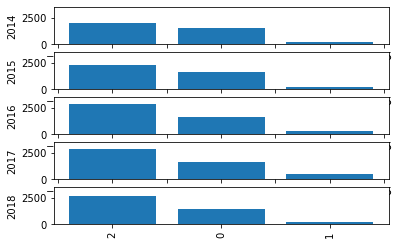

In [10]:
#Plotting the strategy distributions
df_2014_strategy = df_2014_factorized['Strategy'].value_counts()
df_2015_strategy = df_2015_factorized['Strategy'].value_counts()
df_2016_strategy = df_2016_factorized['Strategy'].value_counts()
df_2017_strategy = df_2017_factorized['Strategy'].value_counts()
df_2018_strategy = df_2018_factorized['Strategy'].value_counts()
       
plt.title('Strategy Distributions', fontsize=20)
plt.subplot(5, 1, 1)
year_2014 = plt.bar(np.arange(len(df_2014_strategy)), df_2014_strategy)
plt.ylabel('2014')
plt.ylim([0, 3500])

plt.subplot(5, 1, 2)
year_2015 = plt.bar(np.arange(len(df_2015_strategy)), df_2015_strategy)
plt.ylabel('2015')
plt.ylim([0, 3500])

plt.subplot(5, 1, 3)
year_2016 = plt.bar(np.arange(len(df_2016_strategy)), df_2016_strategy)
plt.ylabel('2016')
plt.ylim([0, 3500])

plt.subplot(5, 1, 4)
year_2017 = plt.bar(np.arange(len(df_2017_strategy)), df_2017_strategy)
plt.ylabel('2017')
plt.ylim([0, 3500])

plt.subplot(5,1,5)
year_2018 = plt.bar(np.arange(len(df_2018_strategy)), df_2018_strategy)
plt.ylabel('2018')
plt.ylim([0, 3500])
plt.xticks(np.arange(len(df_2018_strategy)), df_2018_strategy.index.values.tolist(), rotation = 90)

plt.show()

## 2.3 Handling missing values

### 2.3.1 Columns

Financial Data 2014 - zero values

In [11]:
#Identification of missing and zero values
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#Check zero values per column
percentage_of_zeroes_2014 = round(df_2014_factorized[df_2014_factorized == 0].count(axis = 0) * 100 / len(df_2014_factorized), 1)
df_zeroes_2014 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2014})
df_zeroes_2014.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#print(df_zeroes_2014)

Financial Data 2014 - nan values

In [12]:
#Check nan values per column
percentage_of_nan_2014 = round(df_2014_factorized.isnull().sum() * 100 / len(df_2014_factorized), 1)
df_nan_2014 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2014})
df_nan_2014.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#print(df_nan_2014)

Besides just getting a first feel for our data set concerning zero and nan values, we also took a closer look at features with extreme or identical percentage values.

Hereby we discovered a great amount of duplicate columns and other useless features, which are removed next. As all the data sets consist of the same columns, these will also be removed in the 2015-2018 data sets.

As the fractions of zero and nan values may, and most certainly will vary from one year to another, we decided to drop columns due to their overstepping of a certain threshold after combining the cleaned data sets.

### 2.3.1.1 Drop columns – Unnecessary features

In [13]:
useless_feature_columns = ['cashConversionCycle', 'operatingCycle', 'operatingProfitMargin']

duplicates = ['priceToSalesRatio', 'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', \
              'dividendYield', 'ebitperRevenue', 'grossProfitMargin', 'returnOnEquity', 'returnOnCapitalEmployed', \
              'eBTperEBIT', 'eBITperRevenue', 'payablesTurnover', 'inventoryTurnover', 'currentRatio', \
              'daysOfPayablesOutstanding', 'debtEquityRatio', 'interestCoverage', 'payoutRatio', 'dividendPayoutRatio', \
              'niperEBT', 'cashFlowCoverageRatios', 'Return on Tangible Assets', 'PTB ratio', 'PB ratio', \
              'Cash per Share', 'Operating Cash Flow per Share', 'Debt to Assets']

columns_to_drop = useless_feature_columns + duplicates

df_2014_factorized = df_2014_factorized.drop(columns = columns_to_drop)
df_2015_factorized = df_2015_factorized.drop(columns = columns_to_drop)
df_2016_factorized = df_2016_factorized.drop(columns = columns_to_drop)
df_2017_factorized = df_2017_factorized.drop(columns = columns_to_drop)
df_2018_factorized = df_2018_factorized.drop(columns = columns_to_drop)

### 2.3.1.2 Drop columns – Zero values

Financial Data 2014 - zero values

In [14]:
#Check zero values per column
percentage_of_zeroes_2014 = round(df_2014_factorized[df_2014_factorized == 0].count(axis = 0) * 100 / len(df_2014_factorized), 1)
df_zeroes_2014 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2014})
df_zeroes_2014.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2014)

Financial Data 2015 - zero values

In [15]:
#Check zero values per column
percentage_of_zeroes_2015 = round(df_2015_factorized[df_2015_factorized == 0].count(axis = 0) * 100 / len(df_2015_factorized), 1)
df_zeroes_2015 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2015})
df_zeroes_2015.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2015)

Financial Data 2016 - zero values

In [16]:
#Check zero values per column
percentage_of_zeroes_2016 = round(df_2016_factorized[df_2016_factorized == 0].count(axis = 0) * 100 / len(df_2016_factorized), 1)
df_zeroes_2016 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2016})
df_zeroes_2016.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2016)

Financial Data 2017 - zero values

In [17]:
#Check zero values per column
percentage_of_zeroes_2017 = round(df_2017_factorized[df_2017_factorized == 0].count(axis = 0) * 100 / len(df_2017_factorized), 1)
df_zeroes_2017 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2017})
df_zeroes_2017.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2017)

Financial Data 2018 - zero values

In [18]:
#Check zero values per column
percentage_of_zeroes_2018 = round(df_2018_factorized[df_2018_factorized == 0].count(axis = 0) * 100 / len(df_2018_factorized), 1)
df_zeroes_2018 = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_2018})
df_zeroes_2018.sort_values('Percentage of Zero Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_zeroes_2018)

When comparing the Zero Value Percentage Columns, corrected from the factorized sector columns, then we can see, that there are the following columns present with a threshold of more than 50%:

2014: <br>
Preferred Dividends                                              (83.7)<br>
Net Income - Discontinued ops                                    (80.0)<br>
Deposit Liabilities                                              (79.6)<br>
R&D to Revenue                                                   (65.0)<br>
Net Income - Non-Controlling int                                 (64.4)<br>
Deferred revenue                                                 (62.4)<br>
R&D Expenses                                                     (61.5)<br>
R&D Expense Growth                                               (60.0)<br>
Dividends per Share Growth                                       (57.3)<br>
Effect of forex changes on cash                                  (51.4)<br>
3Y Dividend per Share Growth (per Share)                         (51.1)<br>
Dividend Yield                                                   (50.5)<br>
Dividend per Share                                               (50.3)<br>
<br>
<br>
2015: <br>
Preferred Dividends                                              (81.8)<br>
Net Income - Discontinued ops                                    (80.0)<br>
Deposit Liabilities                                              (78.1)<br>
R&D to Revenue                                                   (62.5)<br>
Net Income - Non-Controlling int                                 (62.3)<br>
Deferred revenue                                                 (60.8)<br>
R&D Expenses                                                     (59.1)<br>
Short-term investments                                           (58.5)<br>
R&D Expense Growth                                               (58.3)<br>
Dividends per Share Growth                                       (55.9)<br>
<br>
<br>
2016:<br>
Preferred Dividends                                              (75.0)<br>
Net Income - Discontinued ops                                    (74.2)<br>
Deposit Liabilities                                              (71.3)<br>
Net Income - Non-Controlling int                                 (57.2)<br>
R&D to Revenue                                                   (56.7)<br>
Deferred revenue                                                 (55.2)<br>
Short-term investments                                           (54.7)<br>
R&D Expenses                                                     (53.4)<br>
R&D Expense Growth                                               (52.8)<br>
Dividends per Share Growth                                       (52.7)<br>
<br>
<br>
2017:<br>
Net Income - Discontinued ops                                    (74.2)<br>
Preferred Dividends                                              (73.3)<br>
Deposit Liabilities                                              (70.4)<br>
Net Income - Non-Controlling int                                 (56.0)<br>
R&D to Revenue                                                   (55.7)<br>
Deferred revenue                                                 (55.4)<br>
Short-term investments                                           (53.8)<br>
Dividends per Share Growth                                       (53.0)<br>
R&D Expenses                                                     (52.5)<br>
R&D Expense Growth                                               (52.2)<br>
<br>
<br>
2018:<br>
Preferred Dividends                                              (83.5)<br>
Deposit Liabilities                                              (79.8)<br>
Deferred revenue                                                 (64.2)<br>
R&D to Revenue                                                   (63.1)<br>
Net Income - Non-Controlling int                                 (63.0)<br>
Short-term investments                                           (59.7)<br>
R&D Expenses                                                     (59.6)<br>
R&D Expense Growth                                               (59.4)<br>
Dividends per Share Growth                                       (58.4)<br>
3Y Dividend per Share Growth (per Share)                         (55.1)<br>
Tax assets                                                       (52.6)<br>
<br>
<br>
Due to these findings, we decided to further remove from all data sets the following columns

In [19]:
zero_value_drops = ['Preferred Dividends', 'Net Income - Discontinued ops', 'Deposit Liabilities', 'Deferred revenue', \
                   'Net Income - Non-Controlling int', 'R&D to Revenue', 'R&D Expenses', 'Short-term investments', \
                   'R&D Expense Growth', 'Dividends per Share Growth']

df_2014_factorized = df_2014_factorized.drop(columns = zero_value_drops)
df_2015_factorized = df_2015_factorized.drop(columns = zero_value_drops)
df_2016_factorized = df_2016_factorized.drop(columns = zero_value_drops)
df_2017_factorized = df_2017_factorized.drop(columns = zero_value_drops)
df_2018_factorized = df_2018_factorized.drop(columns = zero_value_drops)

### 2.3.1.2 Drop columns – NaN values

Financial Data 2014 - NaN values

In [20]:
#Check nan values per column
percentage_of_nan_2014 = round(df_2014_factorized.isnull().sum() * 100 / len(df_2014_factorized), 1)
df_nan_2014 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2014})
df_nan_2014.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2014)

Financial Data 2015 - NaN values

In [21]:
#Check nan values per column
percentage_of_nan_2015 = round(df_2015_factorized.isnull().sum() * 100 / len(df_2015_factorized), 1)
df_nan_2015 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2015})
df_nan_2015.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2015)

Financial Data 2016 - NaN values

In [22]:
#Check nan values per column
percentage_of_nan_2016 = round(df_2016_factorized.isnull().sum() * 100 / len(df_2016_factorized), 1)
df_nan_2016 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2016})
df_nan_2016.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2016)

Financial Data 2017 - NaN values

In [23]:
#Check nan values per column
percentage_of_nan_2017 = round(df_2017_factorized.isnull().sum() * 100 / len(df_2017_factorized), 1)
df_nan_2017 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2017})
df_nan_2017.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2017)

Financial Data 2018 - NaN values

In [24]:
#Check nan values per column
percentage_of_nan_2018 = round(df_2018_factorized.isnull().sum() * 100 / len(df_2018_factorized), 1)
df_nan_2018 = pd.DataFrame({'Percentage of nan Values': percentage_of_nan_2018})
df_nan_2018.sort_values('Percentage of nan Values', inplace = True, ascending = False)

#OPTIONAL
#print(df_nan_2018)

When comparing the NaN Value Percentage Columns we can see, that there are the following columns present with a threshold of missing values above 40%:

2014: <br>
shortTermCoverageRatios                                         51.4<br>
cashFlowToDebtRatio                                             41.9<br>
10Y Shareholders Equity Growth (per Share)                      41.6<br>
10Y Revenue Growth (per Share)                                  40.6<br>
10Y Net Income Growth (per Share)                               40.6<br>
10Y Operating CF Growth (per Share)                             40.3<br>
<br>
<br>
2015: <br>
shortTermCoverageRatios                                         46.7<br>
10Y Shareholders Equity Growth (per Share)                      42.9<br>
10Y Revenue Growth (per Share)                                  42.2<br>
10Y Net Income Growth (per Share)                               42.2<br>
10Y Operating CF Growth (per Share)                             41.9<br>
<br>
<br>
2016: <br>
shortTermCoverageRatios                                         50.4<br>
10Y Shareholders Equity Growth (per Share)                      47.7<br>
10Y Net Income Growth (per Share)                               47.4<br>
10Y Revenue Growth (per Share)                                  47.4<br>
10Y Operating CF Growth (per Share)                             47.1<br>
priceEarningsToGrowthRatio                                      46.2<br>
10Y Dividend per Share Growth (per Share)                       46.1<br>
Net Debt to EBITDA                                              44.1<br>
nIperEBT                                                        43.5<br>
effectiveTaxRate                                                43.5<br>
ebtperEBIT                                                      41.4<br>
Net Debt                                                        40.5<br>
Other Assets                                                    40.3<br>
<br>
<br>
2017: <br>
shortTermCoverageRatios                                         50.8<br>
10Y Shareholders Equity Growth (per Share)                      47.3<br>
10Y Net Income Growth (per Share)                               46.8<br>
10Y Revenue Growth (per Share)                                  46.8<br>
10Y Operating CF Growth (per Share)                             46.6<br>
10Y Dividend per Share Growth (per Share)                       45.8<br>
priceEarningsToGrowthRatio                                      45.6<br>
Net Debt to EBITDA                                              44.4<br>
effectiveTaxRate                                                43.2<br>
nIperEBT                                                        43.2<br>
ebtperEBIT                                                      41.0<br>
<br>
<br>
2018: <br>
shortTermCoverageRatios                                         43.9<br>
<br>
<br>
Due to these findings, we decided to further remove from all data sets the following columns

In [25]:
nan_values_drop = ['shortTermCoverageRatios', '10Y Shareholders Equity Growth (per Share)', \
                   '10Y Net Income Growth (per Share)', '10Y Revenue Growth (per Share)', \
                  '10Y Operating CF Growth (per Share)', '10Y Dividend per Share Growth (per Share)']

df_2014_factorized = df_2014_factorized.drop(columns = nan_values_drop)
df_2015_factorized = df_2015_factorized.drop(columns = nan_values_drop)
df_2016_factorized = df_2016_factorized.drop(columns = nan_values_drop)
df_2017_factorized = df_2017_factorized.drop(columns = nan_values_drop)
df_2018_factorized = df_2018_factorized.drop(columns = nan_values_drop)

When looking at the dropped columns above, it also makes sense, in our opinion, from an economical point of view to drop these 10 year metrics, as we see such a long period as too long to be of any use.

### 2.3.2 Rows

We decided to delete rows which still have more than 48 NaN values. I.e. all rows need at least 144 Non-NaN-values in their 192 columns. These values are chosen since in this case, 75% of all values of every row are Non-NaN-values which seams plausible for us. If you have to impute more than every fourth value, we don't see the legitimacy to still include such a row into our dataframe.
We therefore delete XXX out of XXX rows (XXXX %).

In [26]:
#delete rows which have less than 144 Non-NaN values
df_2014_factorized.dropna(axis=0, thresh=144, inplace=True)
df_2015_factorized.dropna(axis=0, thresh=144, inplace=True)
df_2016_factorized.dropna(axis=0, thresh=144, inplace=True)
df_2017_factorized.dropna(axis=0, thresh=144, inplace=True)
df_2018_factorized.dropna(axis=0, thresh=144, inplace=True)

## 2.4 Outlier Handling

We decided to handle possible outliers on a per year data set level. Furthermore, it is in our opinion of importance to do this task sectorwise. We define the upper 5 and lower 5 percent of all values in every year and sector as outliers and replace it with the corresponding threshold.

In [27]:
upper_quantile_threshold = 0.95
lower_quantile_threshold = 0.05

Financial Data 2014

In [28]:
#OPTIONAL check if Outlier handling works (see below as well)
#df_2014_factorized[df_2014_factorized['Consumer Defensive']==1].describe()

In [29]:
factorized_dfs = [df_2014_factorized, df_2015_factorized, df_2016_factorized, df_2017_factorized,df_2018_factorized]
imputed_factorized = [None] * 5
for i in range(len(factorized_dfs)):
    df_factorized = factorized_dfs[i]
    df_sectors_strategy = df_factorized.iloc[:, -12:]
    
    df_factorized_copy = df_factorized.drop(columns = ['Consumer Cyclical', 'Consumer Defensive', \
                                                                'Energy', 'Financial Services', 'Healthcare', 'Industrials', \
                                                                'Real Estate', 'Technology', 'Utilities', 'Basic Materials', \
                                                                 'Communication Services', 'Strategy'])
    sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
    df_names = {'CD':[],'BM':[],'HC':[],'CC':[],'II':[],'RE':[],
            'CS':[],'EE':[],'FS':[],'UU':[],'TC':[]}
    dfs_to_check = []
    for i, j in zip(sectors, df_names):
        df_names[j] = df_factorized_copy[df_factorized[i] == 1].values
        df_names[j] = pd.DataFrame(df_names[j])
        dfs_to_check.append(df_names[j])

    new_dfs = []
    for i in range(len(dfs_to_check)):
        df_deep_copy = dfs_to_check[i].copy(deep = True)
        top_quantiles = df_deep_copy.quantile(upper_quantile_threshold)
        outliers_top = (df_deep_copy > top_quantiles)

        low_quantiles = df_deep_copy.quantile(lower_quantile_threshold)
        outliers_low = (df_deep_copy < low_quantiles)

        df_deep_copy = df_deep_copy.mask(outliers_top, top_quantiles, axis=1)
        df_deep_copy = df_deep_copy.mask(outliers_low, low_quantiles, axis=1)

        new_dfs.append(df_deep_copy)

    df_factorized = pd.concat(new_dfs)
    df_factorized['Strategy'] = df_sectors_strategy['Strategy']
    for i in sectors:
        df_factorized[i] = df_sectors_strategy[i]   

In [30]:
#OPTIONAL check if Outlier handling works (see above as well)
#df_2014_factorized[df_2014_factorized['Consumer Defensive']==1].describe()

## 2.5 Imputation of missing values

We decided to impute missing values on a per year data set level. Furthermore, it is in our opinion of importance to do this task sectorwise as the outlier handling. We imputed with the median strategy with the help of SimpleImputer.

In [32]:
factorizeds = [df_2014_factorized, df_2015_factorized, df_2016_factorized, df_2017_factorized,df_2018_factorized]
imputed_factorized = [None] * 5
for k in range(len(factorizeds)):
    factorized = factorizeds[k]
    sectors = ['Consumer Defensive','Basic Materials','Healthcare', 'Consumer Cyclical', 'Industrials','Real Estate', 'Communication Services',
          'Energy', 'Financial Services','Utilities','Technology']
    df_names = {'imp_CD':[],'imp_BM':[],'imp_HC':[],'imp_CC':[],'imp_II':[],'imp_RE':[],
            'imp_CS':[],'imp_EE':[],'imp_FS':[],'imp_UU':[],'imp_TC':[]}
    frames_to_concat = []
    for i, j in zip(sectors, df_names):
        ipr = SimpleImputer(missing_values=np.nan, strategy='median')
        ipr = ipr.fit(factorized[factorized[i] == 1].values)
        df_names[j] = ipr.transform(factorized[factorized[i] == 1].values)
        df_names[j] = pd.DataFrame(df_names[j])
        frames_to_concat.append(df_names[j])

    df_factorized_imputed = pd.concat(frames_to_concat)
    df_factorized_imputed.columns = factorized.columns
    imputed_factorized[k] = df_factorized_imputed

Finally, we can concatenate our yearly data frames.

In [33]:
#Concatenating all yearly data frames
all_frames = [imputed_factorized[0], imputed_factorized[1], imputed_factorized[2], \
              imputed_factorized[3], imputed_factorized[4]]

df_complete = pd.concat(all_frames)

We than do a zero-value-check again. Because we imputed with the median (which can be zero of course), it's possible that some columns now have a high number of zero-values.

In [34]:
#Check zero values per column
percentage_of_zeroes_complete = df_complete[df_complete == 0].count(axis = 0) *100 / len(df_complete)
df_zeroes_complete = pd.DataFrame({'Percentage of Zero Values': percentage_of_zeroes_complete})
df_zeroes_complete.sort_values('Percentage of Zero Values', inplace = True, ascending = False)


print(df_zeroes_complete)

                                           Percentage of Zero Values
Communication Services                                     98.101201
Utilities                                                  97.536143
Consumer Defensive                                         95.642435
Energy                                                     94.405416
Real Estate                                                94.257789
Basic Materials                                            93.499287
Consumer Cyclical                                          88.123600
Industrials                                                86.540419
Technology                                                 84.575443
Healthcare                                                 83.715129
Financial Services                                         83.603136
year_2014                                                  81.892690
year_2015                                                  80.706577
year_2016                         

In [35]:
#Again we drop columns with zero values percentages above 50%
#wegen median imputation können die 0-Werte wieder steigen -> mehr Spalten rausschmeissen
zero_values_drops_complete = ['5Y Dividend per Share Growth (per Share)', '3Y Dividend per Share Growth (per Share)', \
                              'Tax assets', 'Acquisitions and disposals', 'Effect of forex changes on cash', \
                              'Inventory Growth', 'Payout Ratio']

df_complete = df_complete.drop(columns = zero_values_drops_complete)

# 3 Machine Learning Data Analysis

## 3.1 ML Data Preparation

### 3.1.1. Train-Test-Split

Define Strategy as the response variable. Split into train and test set.

In [36]:
cols = df_complete.columns.values
y = df_complete['Strategy']
X = df_complete.drop(['Strategy'],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

#OPTIONAL check shapes
#print(X_train.shape)
#print(X_test.shape)
#print(y_train.shape)
#print(y_test.shape)

X_train_lda_qda = X_train
y_train_lda_qda = y_train
X_test_lda_qda = X_test
y_test_lda_qda = y_test

### 3.1.2 Class Imbalance

As seen at the very top of the notebook, there is a huge class imbalance. It's crucial to train our models on a balanced train set. Note that we balance only after the train-test-split on the train set such that the test set is not containing artificial data which happens while balancing. Our test set still just contains real data.

In [37]:
print('BEFORE balancing dataset shape %s' % Counter(y_train))
sm = SMOTE(random_state=1, sampling_strategy='all', k_neighbors=10, n_jobs=-1)
X_train, y_train = sm.fit_resample(X_train,y_train)
print('AFTER balancing dataset shape %s' % Counter(y_train))

BEFORE balancing dataset shape Counter({2.0: 7440, 0.0: 5477, 1.0: 833})
AFTER balancing dataset shape Counter({2.0: 7440, 0.0: 7440, 1.0: 7440})


### 3.1.3 Feature Selection

After trying out many thresholds on all models we decided to select all features with at least 0.0055 rel. feature importance which holds for 81 features. Note that years are very important features.

 1) year_2015 0.0176
 2) year_2017 0.0150
 3) year_2018 0.0142
 4) year_2016 0.0128
 5) Dividend per Share 0.0117
 6) Dividend Yield 0.0110
 7) year_2014 0.0107
 8) PFCF ratio 0.0101
 9) Dividend payments 0.0094
10) PE ratio 0.0092
11) 3Y Net Income Growth (per Share) 0.0073
12) 5Y Net Income Growth (per Share) 0.0073
13) Long-term investments 0.0072
14) POCF ratio 0.0070
15) Graham Number 0.0068
16) Intangibles to Total Assets 0.0068
17) EV to Sales 0.0068
18) Total non-current liabilities 0.0065
19) Other comprehensive income 0.0065
20) dividendpaidAndCapexCoverageRatios 0.0065
21) Current ratio 0.0064
22) Net Income per Share 0.0064
23) ROIC    0.0064
24) Investments 0.0064
25) Enterprise Value over EBITDA 0.0063
26) EV to Free cash flow 0.0063
27) Total non-current assets 0.0063
28) Earnings Yield 0.0063
29) Short-term debt 0.0063
30) Working Capital 0.0063
31) Capex to Operating Cash Flow 0.0063
32) Goodwill and Intangible Assets 0.0062
33) fixedAssetTurnover 0.0062
34) Weighted A

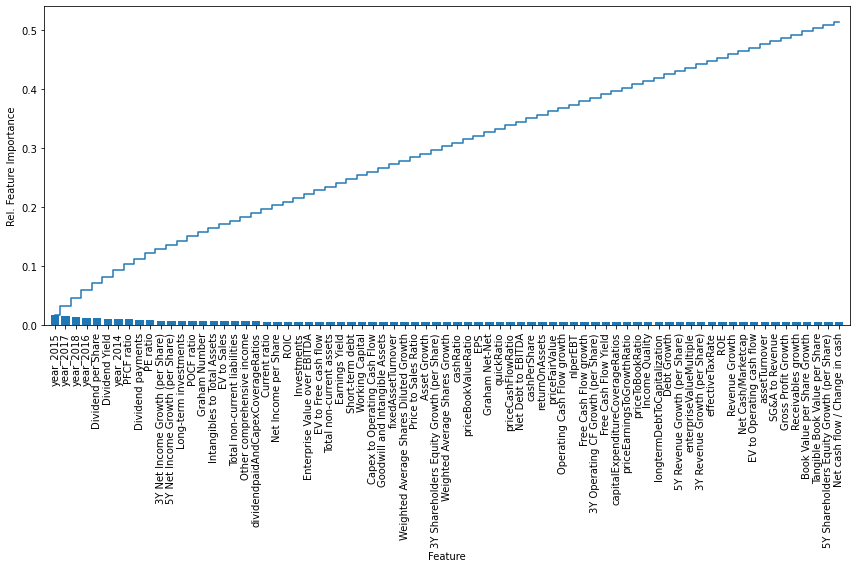

In [38]:
important_features = helper_functions.feature_selection(x = X_train, y = y_train.values.ravel(), thres=0.0055)

In [39]:
#Subset important features matrix for ML algorithms
X_train = X_train.loc[:,important_features]
X_test = X_test.loc[:, important_features]

## 3.2 ML Algorithms

SORTIEREN NACH END SCORE plus hier tabelle der scores

### 3.2.1. Random Forest

Parameters found with Grid Search

In [40]:
param_grid = {"n_estimators": [70],
                  'max_depth': [25],
                  'min_samples_split': [2],
                  'min_samples_leaf': [1]},

# Run brute-force grid search
grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv= 5, n_jobs=-1)
grid = grid.fit(X_train, y_train)
print('Best CV accuracy: {:.4f}'.format(grid.best_score_))
print('Test score:       {:.4f}'.format(grid.score(X_test,y_test)))
print('Best parameters: {}'.format(grid.best_params_))

# Predict classes
y_pred = grid.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True','Predicted']).size().unstack('Predicted'))
print('\n')
print(metrics.classification_report(y_test, y_pred))

Best CV accuracy: 0.7270
Test score:       0.6110
Best parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 70}
Predicted   Buy  Hold  Sell
True                       
Buy        1170    48  1130
Hold        145    12   200
Sell        718    52  2419


              precision    recall  f1-score   support

         0.0       0.58      0.50      0.53      2348
         1.0       0.11      0.03      0.05       357
         2.0       0.65      0.76      0.70      3189

    accuracy                           0.61      5894
   macro avg       0.44      0.43      0.43      5894
weighted avg       0.58      0.61      0.59      5894



### 3.2.2. Decision Tree

In [41]:
# Max depth
maxDepth = np.array([15])

# Minimum number of samples required to split any internal node 
minSamplesNode = np.array([2])

# The minimum number of samples required to be at a leaf/terminal node
minSamplesLeaf = np.array([2])

In [42]:
kFold = StratifiedKFold(n_splits=10)

# Define the hyperparameter values to be tested
param_grid = {'criterion': ['gini'],
              'max_depth': maxDepth,
              'min_samples_split': minSamplesNode,
              'min_samples_leaf': minSamplesLeaf}

# Run brute-force grid search
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=kFold, n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True','Predicted']).size().unstack('Predicted'))
print('\n')
print(metrics.classification_report(y_test, y_pred))

0.6039426523297491
{'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}
Predicted   Buy  Hold  Sell
True                       
Buy        1170    48  1130
Hold        145    12   200
Sell        718    52  2419


              precision    recall  f1-score   support

         0.0       0.58      0.50      0.53      2348
         1.0       0.11      0.03      0.05       357
         2.0       0.65      0.76      0.70      3189

    accuracy                           0.61      5894
   macro avg       0.44      0.43      0.43      5894
weighted avg       0.58      0.61      0.59      5894



### 3.2.2. MLP classifier

In [43]:
#mlp = MLPClassifier(random_state=0, solver= "lbfgs", warm_start= True)

pipe = Pipeline([('scaler', StandardScaler()), 
                     ('neural', MLPClassifier())])
    
# Define the hyperparameter values to be tested
param_grid = {"neural__hidden_layer_sizes" :[50],
                  'neural__max_iter': [150]},


# Run brute-force grid search
#solver "lbfgs" has proven to be the best
grid = GridSearchCV(pipe,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv= 5, n_jobs=-1)
grid = grid.fit(X_train, y_train)
                                               


C:\Users\Marco\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
print('Best CV accuracy: {:.4f}'.format(grid.best_score_))
print('Test score:       {:.4f}'.format(grid.score(X_test,y_test)))
print('Best parameters: {}'.format(grid.best_params_))

# Predict classes
y_pred = grid.predict(X_test)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True','Predicted']).size().unstack('Predicted'))
print('\n')
print(metrics.classification_report(y_test, y_pred))

Best CV accuracy: 0.6045
Test score:       0.5249
Best parameters: {'neural__hidden_layer_sizes': 50, 'neural__max_iter': 150}
Predicted   Buy  Hold  Sell
True                       
Buy        1121   251   976
Hold        133    60   164
Sell       1002   274  1913


              precision    recall  f1-score   support

         0.0       0.50      0.48      0.49      2348
         1.0       0.10      0.17      0.13       357
         2.0       0.63      0.60      0.61      3189

    accuracy                           0.52      5894
   macro avg       0.41      0.42      0.41      5894
weighted avg       0.54      0.52      0.53      5894



### 3.2.3 SVM

TODO: in Bericht integrieren, nicht hier!!

Support Vector Machines

SVMs delivered disappointing results in our case. Nevertheless, we included the algorithms within our Python Notebook. For both linear and polynomial kernel functions we didn’t reach test scores above 0.5. We should note that the train scores for the polynomial versions are high (above 0.7) but are in great discrepancy with the test scores. 
As recommended in the script, we worked with the standardized version of the train and test sets.
With growing parameter C, the runtimes went into the hours very fast such that we are not 100 percent sure to have found the best parameters. Nevertheless, it seems very unlikely that the score would improve onto the level of the Random Forest because the difference is just too big.



In [45]:
# Create StandardScaler object
sc = StandardScaler()

# Standardize features
X_train_std = sc.fit_transform(X_train)

# Transform test set
X_test_std = sc.transform(X_test)

In [46]:
# Create object
svm_linear = SVC(kernel='linear', C=1.0)
svm_linear

# Fit linear SVM to standardized training set
svm_linear.fit(X_train_std, y_train)

# Print results
print("Observed probability of non-default: {:.2f}".format(np.count_nonzero(y_train==0) / len(y_train)))
print("Train score: {:.2f}".format(svm_linear.score(X_train_std, y_train)))
print("Test score:  {:.2f}".format(svm_linear.score(X_test_std, y_test)))

y_pred = svm_linear.predict(X_test_std)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True','Predicted']).size().unstack('Predicted'))
print('\n')
print(metrics.classification_report(y_test, y_pred))

Observed probability of non-default: 0.33
Train score: 0.43
Test score:  0.41
Predicted  Buy  Hold  Sell
True                      
Buy        719   726   903
Hold        70   135   152
Sell       621   999  1569


              precision    recall  f1-score   support

         0.0       0.51      0.31      0.38      2348
         1.0       0.07      0.38      0.12       357
         2.0       0.60      0.49      0.54      3189

    accuracy                           0.41      5894
   macro avg       0.39      0.39      0.35      5894
weighted avg       0.53      0.41      0.45      5894



In [47]:
svm_poly = SVC(kernel='poly', random_state=1)

# Fit linear SVM to standardized training set
svm_poly.fit(X_train_std, y_train)

# Print results
print("Train score: {:.2f}".format(svm_poly.score(X_train_std, y_train)))
print("Test score:  {:.2f}".format(svm_poly.score(X_test_std, y_test)))

y_pred = svm_poly.predict(X_test_std)

# Manual confusion matrix as pandas DataFrame
confm = pd.DataFrame({'Predicted': y_pred,
                      'True': y_test})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True','Predicted']).size().unstack('Predicted'))
print('\n')
print(metrics.classification_report(y_test, y_pred))

Train score: 0.49
Test score:  0.30
Predicted   Buy  Hold  Sell
True                       
Buy        1269   954   125
Hold        146   195    16
Sell       1401  1477   311


              precision    recall  f1-score   support

         0.0       0.45      0.54      0.49      2348
         1.0       0.07      0.55      0.13       357
         2.0       0.69      0.10      0.17      3189

    accuracy                           0.30      5894
   macro avg       0.40      0.39      0.26      5894
weighted avg       0.56      0.30      0.30      5894



beschreiben. pipeline didn't help...

### 3.2.4 LDA/QDA

#### 3.2.4.1 LDA

In [48]:
lda = LDA(shrinkage='auto', solver='eigen') # default solver='svd', shrinkage=None
lda = lda.fit(X_train_lda_qda, y_train_lda_qda)

# Predict labels
y_pred_lda = lda.predict(X_test_lda_qda) # vector of 1, 2, 3s --> prediction --> in confusion matrix

# Print perfomance metrics 
print('score qda: {0: .4f}'.format(metrics.accuracy_score(y_test_lda_qda, y_pred_lda)))
confm = pd.DataFrame({'Predicted status': y_pred_lda,
                      'True status': y_test_lda_qda})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True status','Predicted status']).size().unstack('Predicted status'))
print('\n')
print(metrics.classification_report(y_test_lda_qda, y_pred_lda))

score qda:  0.5758
Predicted status  Buy  Hold  Sell
True status                      
Buy               765    11  1572
Hold               87     2   268
Sell              538    24  2627


              precision    recall  f1-score   support

         0.0       0.55      0.33      0.41      2348
         1.0       0.05      0.01      0.01       357
         2.0       0.59      0.82      0.69      3189

    accuracy                           0.58      5894
   macro avg       0.40      0.39      0.37      5894
weighted avg       0.54      0.58      0.53      5894



In [49]:
# TODO Machen wir jetzt 2 files oder nicht? Falls 2 files dann müsste man diesen Block in diesem file komplett entfernen
# da es den gridsearch macht

# LDA Gridsearch
grid = GridSearchCV(estimator=LDA(),
                  param_grid={'solver': ('lsqr', 'eigen', 'svd'), 'shrinkage': (None, 'auto')},
                  scoring='accuracy', n_jobs=-1)
grid = grid.fit(X_train, y_train)

y_pred_grid = grid.predict(X_test)

print('score: {0: .4f}'.format(metrics.accuracy_score(y_test_lda_qda, y_pred_grid)))
print('error-rate: {0: .4f}'.format(1-metrics.accuracy_score(y_test_lda_qda, y_pred_grid)))
print('\n')
print(metrics.confusion_matrix(y_test_lda_qda, y_pred_grid))
print('\n')
print(grid.best_estimator_)
# there will be a warning 'UserWarning: One or more of the test scores are non-finite' because solver='svd' can't be
# combined with shrinkage and solver='eigen' needs shrinkage

C:\Users\Marco\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.3625448         nan 0.41680108 0.37007168 0.41433692        nan]
  warnings.warn(


score:  0.4477
error-rate:  0.5523


[[ 715  649  984]
 [  70  111  176]
 [ 567  809 1813]]


LinearDiscriminantAnalysis()


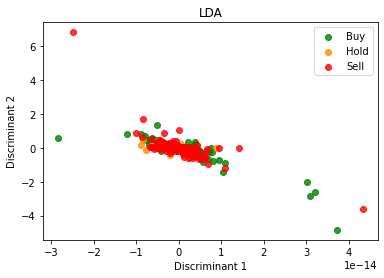

In [50]:
lda_transformed = lda.transform(X_train_lda_qda)
colors = ['green', 'darkorange', 'red']
lw = 2
target_names = ['Buy', 'Hold', 'Sell']
plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(lda_transformed[y_train_lda_qda == i, 0], lda_transformed[y_train_lda_qda == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')
plt.xlabel('Discriminant 1')
plt.ylabel('Discriminant 2')
plt.show()

#### 3.2.4.2 QDA

In [51]:
# Run qda on training data
qda = QDA().fit(X_train_lda_qda, y_train_lda_qda)

# Predict classes for qda
y_pred_qda = qda.predict(X_test_lda_qda)

# Print performance metrics
print('score qda: {0: .4f}'.format(metrics.accuracy_score(y_test_lda_qda, y_pred_qda)))
print('\n')
confm = pd.DataFrame({'Predicted status': y_pred_lda,
                      'True status': y_test_lda_qda})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True status','Predicted status']).size().unstack('Predicted status'))
print('\n')
print(metrics.classification_report(y_test_lda_qda, y_pred_lda))

score qda:  0.1359


Predicted status  Buy  Hold  Sell
True status                      
Buy               765    11  1572
Hold               87     2   268
Sell              538    24  2627


              precision    recall  f1-score   support

         0.0       0.55      0.33      0.41      2348
         1.0       0.05      0.01      0.01       357
         2.0       0.59      0.82      0.69      3189

    accuracy                           0.58      5894
   macro avg       0.40      0.39      0.37      5894
weighted avg       0.54      0.58      0.53      5894



### 3.2.5 Keras Sequential Model

In [52]:
# factorize strategy column in order that the neural network is working
y_train = pd.get_dummies(y_train)

# Define the scaler 
scaler = StandardScaler().fit(X_train)

# Scale the train set
X_train = scaler.transform(X_train)

# Scale the test set
X_test = scaler.transform(X_test)

def base_model():
    # define the model and add layers
    model = Sequential()
    model.add(Dense(np.shape(X_train)[0], input_dim= np.shape(X_train)[1], activation='relu'))
    model.add(Dense(12, activation='relu'))
    model.add(Dense(3, activation ='softmax'))

    # compile the keras model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=base_model, verbose=0)
#define the grid search parameters
batch_size = [100]
epochs = [30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.630914 using {'batch_size': 100, 'epochs': 30}
0.630914 (0.120336) with: {'batch_size': 100, 'epochs': 30}


In [53]:
# predict values with X_test    
y_pred = np.argmax(grid_result.predict(X_test), axis=-1)

# Print performance metrics
print('score Keras model: {0: .4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('\n')
confm = pd.DataFrame({'Predicted status': y_pred,
                      'True status': y_test})
confm.replace(to_replace={0:'Buy', 1:'Hold', 2:'Sell'}, inplace=True)
print(confm.groupby(['True status','Predicted status']).size().unstack('Predicted status'))
print('\n')
print(metrics.classification_report(y_test, y_pred))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


TypeError: Singleton array 0 cannot be considered a valid collection.